mag=2.0, layer=12
@mag=2.0, layer=12, dataset=reasoning, mean=3385.70, min=938, max=9914, std=1907.80, stderr=17.6648
@mag=2.0, layer=12, dataset=awesome, mean=2699.75, min=912, max=8453, std=2130.58, stderr=20.0998
@mag=2.0, layer=12, dataset=gsm8k, mean=1471.08, min=850, max=3217, std=489.13, stderr=4.5290
@mag=2.0, layer=12, dataset=leetcode, mean=2270.47, min=1198, max=5444, std=1257.97, stderr=26.7654
@mag=2.0, layer=12, dataset=test_set, mean=3237.52, min=544, max=6235, std=1902.64, stderr=90.6021
mag=2.0, layer=16
@mag=2.0, layer=16, dataset=reasoning, mean=6437.63, min=1054, max=7320, std=1211.50, stderr=11.2176
@mag=2.0, layer=16, dataset=awesome, mean=6712.01, min=1323, max=7352, std=929.14, stderr=8.7655
@mag=2.0, layer=16, dataset=gsm8k, mean=6517.75, min=2921, max=7150, std=755.41, stderr=6.9946
@mag=2.0, layer=16, dataset=leetcode, mean=6699.98, min=1251, max=7684, std=1152.34, stderr=24.5180
@mag=2.0, layer=16, dataset=test_set, mean=5970.38, min=4648, max=6386, std=368.

Processing datasets:   0%|          | 0/5 [00:00<?, ?it/s]

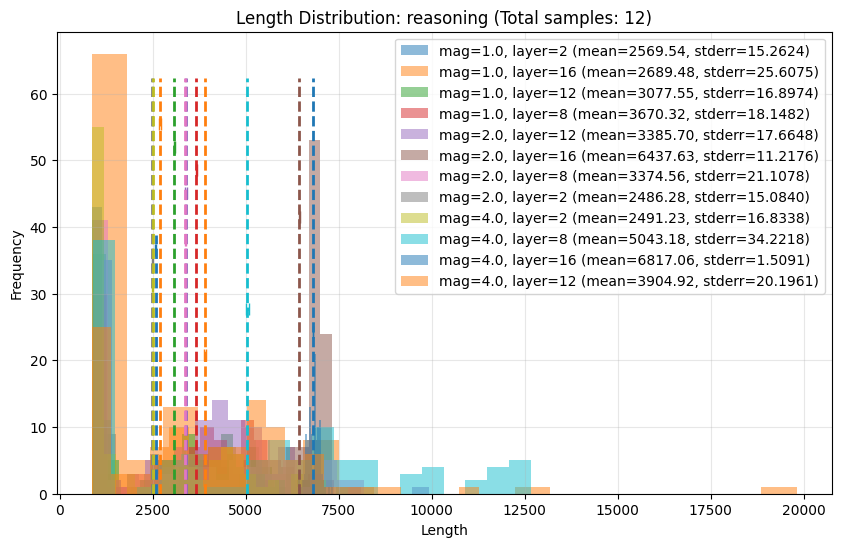

Processing datasets:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

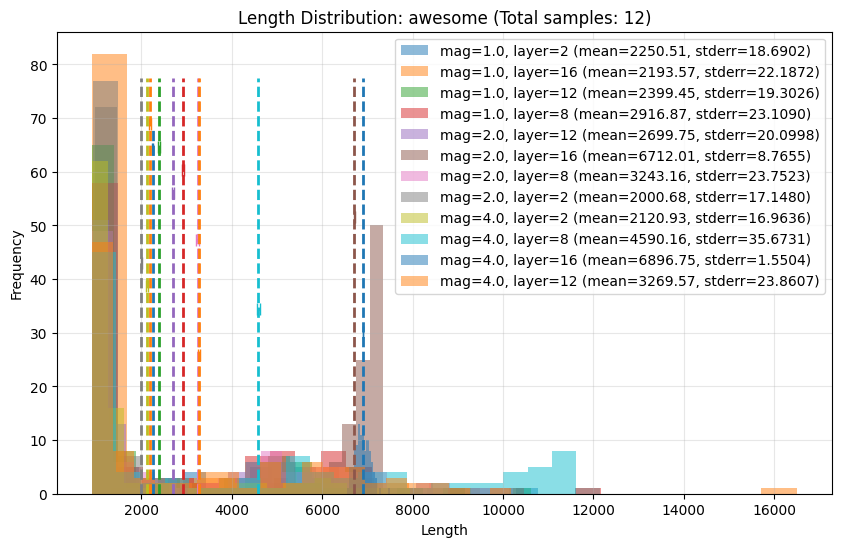

Processing datasets:  40%|████      | 2/5 [00:00<00:01,  2.05it/s]

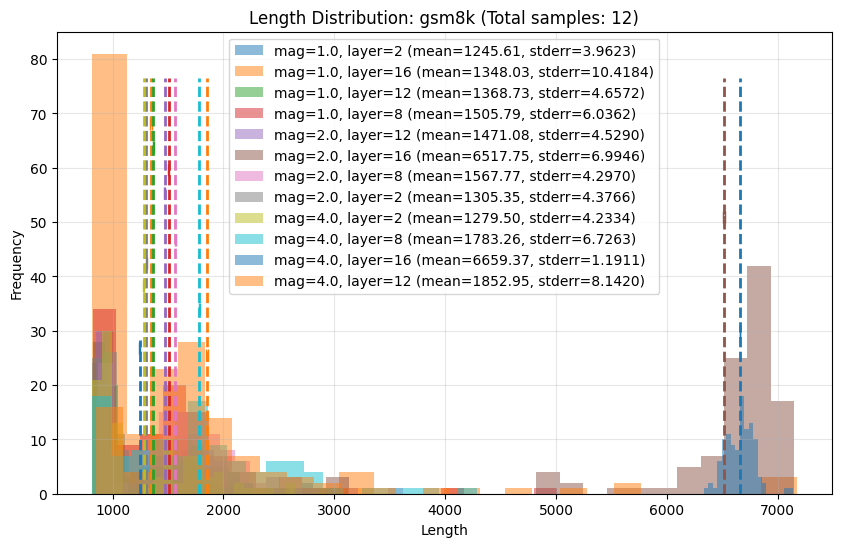

Processing datasets:  60%|██████    | 3/5 [00:01<00:00,  2.09it/s]

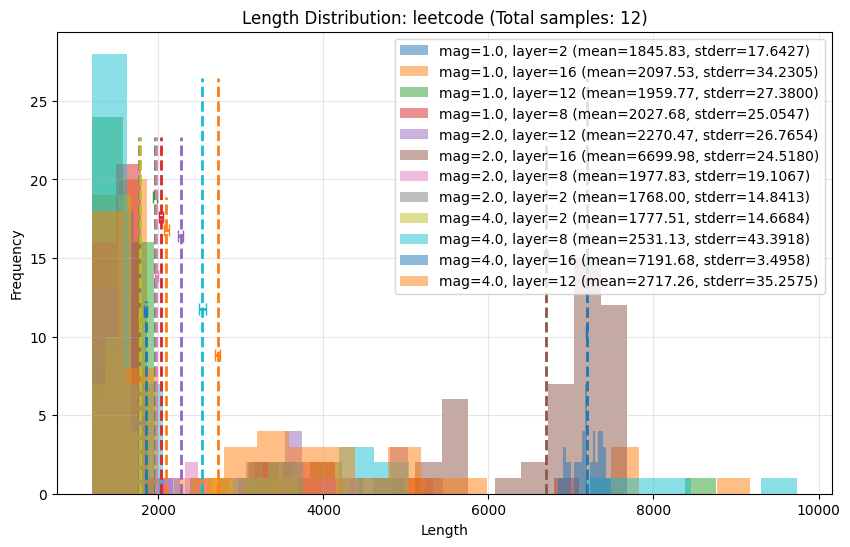

Processing datasets:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

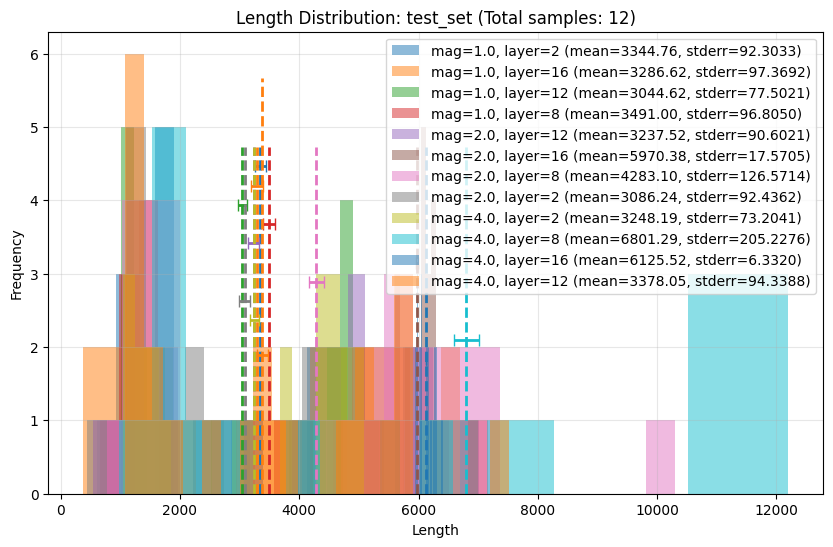

Processing datasets: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


In [25]:
from __future__ import annotations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dotenv
import numpy as np
import os
from pathlib import Path
import tqdm
import json
from pydantic import BaseModel, ConfigDict
"""
8B04545E-B159-4A65-AE77-D474D853FE2E

We simply look at the length statistics of both the generations:
"""
assert os.environ.get("OUTPUT_DIR", None) is not None
results_dir = Path.cwd() / os.environ["OUTPUT_DIR"] / "batched_steering"
assert results_dir.exists() and results_dir.is_dir()
assert all(x.is_file() for x in results_dir.iterdir())
jsons = list(results_dir.glob("*.json"))
output_dir = Path.cwd() / os.environ["OUTPUT_DIR"] / "viz"
assert not output_dir.exists()
dataset2all_histos = {}
class AllHistosInfo(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    mean: float
    max: float
    min: float
    stdev: float
    stderr: float
    lens: np.ndarray
    mag: float
    layer: int

def get_mag_layer(name: str) -> tuple[float, int]:
    mag, layer = float(name.split("mag")[1].split("_")[0]), int(name.split("_layer")[1].split(".")[0])
    return mag, layer
for j in jsons:
    # mag1.0_layer8.json
    # Extract magnitude and layer from the filename
    mag, layer = get_mag_layer(j.name)
    print(f"mag={mag}, layer={layer}")
    dataset2lens = {d: np.array([len(x) for x in xs]) for d, xs in json.loads(j.read_text()).items()} # dict of dataset name: list of interactions
    dataset2means= {d: x.mean() for d, x in dataset2lens.items()}
    dataset2min= {d: x.min() for d, x in dataset2lens.items()}
    dataset2max= {d: x.max() for d, x in dataset2lens.items()}
    dataset2std= {d: x.std() for d, x in dataset2lens.items()}
    dataset2stderr= {d: x.std() / len(x) for d, x in dataset2lens.items()}
    for dataset in dataset2lens:
        print(f"@mag={mag}, layer={layer}, dataset={dataset}, mean={dataset2means[dataset]:.2f}, min={dataset2min[dataset]}, max={dataset2max[dataset]}, std={dataset2std[dataset]:.2f}, stderr={dataset2stderr[dataset]:.4f}") # fmt: skip
    assert len(dataset2all_histos.keys()) == 0 or set(dataset2lens.keys()) == set(dataset2all_histos.keys())
    for dataset in dataset2lens:
        if dataset not in dataset2all_histos:
            dataset2all_histos[dataset] = []
        dataset2all_histos[dataset].append(AllHistosInfo(
            mean=dataset2means[dataset].item(),
            max=dataset2max[dataset].item(),
            min=dataset2min[dataset].item(),
            stdev=dataset2std[dataset].item(),
            stderr=dataset2stderr[dataset].item(),
            lens=dataset2lens[dataset],
            mag=mag,
            layer=layer,
        ))

# Get a list of distinct colors from matplotlib's color maps
colors = list(mcolors.TABLEAU_COLORS.values())
dataset2all_histos = {
    k: sorted(v, key=lambda x: x.mag) for k, v in dataset2all_histos.items()
}
# Sort by mag
for i, (dataset, all_histos) in enumerate(tqdm.tqdm(dataset2all_histos.items(), desc="Processing datasets")):
    plt.figure(figsize=(10, 6))
    for j, histo in enumerate(all_histos):
        color = colors[j % len(colors)]
        plt.hist(histo.lens, bins=20, alpha=0.5, color=color, label=f'mag={histo.mag}, layer={histo.layer} (mean={histo.mean:.2f}, stderr={histo.stderr:.4f})')
        
        # Add vertical line for mean
        ymin, ymax = plt.ylim()
        plt.vlines(x=histo.mean, ymin=0, ymax=ymax*0.9, color=color, linestyle='--', linewidth=2)
        
        # Add horizontal error bar for stderr
        plt.hlines(y=ymax*0.85-j*(ymax*0.05), xmin=histo.mean-histo.stderr, xmax=histo.mean+histo.stderr, 
                  color=color, linewidth=2)
        plt.plot([histo.mean-histo.stderr, histo.mean+histo.stderr], [ymax*0.85-j*(ymax*0.05), ymax*0.85-j*(ymax*0.05)], 
                 color=color, marker='|', markersize=8, linestyle='')
    
    plt.title(f"Length Distribution: {dataset} (Total samples: {len(all_histos)})")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
